add image_preprocessing_ver_3.py

In [0]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, GlobalAveragePooling2D, concatenate


mean = np.array([0.485, 0.456, 0.406], dtype='float32')
std = np.array([0.229, 0.224, 0.225], dtype='float32')


def preprocess_input(x):
    x /= 255.0
    x -= mean
    x /= std
    return x


# a building block of the SqueezeNet architecture
def fire_module(number, x, squeeze, expand, weight_decay=None, trainable=False):
    
    module_name = 'fire' + number
    
    if trainable and weight_decay is not None:
        kernel_regularizer = keras.regularizers.l2(weight_decay) 
    else:
        kernel_regularizer = None
    
    x = Convolution2D(
        squeeze, (1, 1), 
        name=module_name + '/' + 'squeeze',
        trainable=trainable, 
        kernel_regularizer=kernel_regularizer
    )(x)
    x = Activation('relu')(x)

    a = Convolution2D(
        expand, (1, 1),
        name=module_name + '/' + 'expand1x1',
        trainable=trainable, 
        kernel_regularizer=kernel_regularizer
    )(x)
    a = Activation('relu')(a)

    b = Convolution2D(
        expand, (3, 3), padding='same',
        name=module_name + '/' + 'expand3x3',
        trainable=trainable, 
        kernel_regularizer=kernel_regularizer
    )(x)
    b = Activation('relu')(b)

    return concatenate([a, b])


def SqueezeNet(weight_decay, image_size=224):

    image = Input(shape=(image_size, image_size, 3))

    x = Convolution2D(
        64, (3, 3), strides=(2, 2), name='conv1', 
        trainable=False
    )(image) # 111, 111, 64
    
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x) # 55, 55, 64

    x = fire_module('2', x, squeeze=16, expand=64) # 55, 55, 128
    x = fire_module('3', x, squeeze=16, expand=64) # 55, 55, 128
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x) # 27, 27, 128

    x = fire_module('4', x, squeeze=32, expand=128) # 27, 27, 256
    x = fire_module('5', x, squeeze=32, expand=128) # 27, 27, 256
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x) # 13, 13, 256
    
    x = fire_module('6', x, squeeze=48, expand=192) # 13, 13, 384
    x = fire_module('7', x, squeeze=48, expand=192) # 13, 13, 384
    x = fire_module('8', x, squeeze=64, expand=256) # 13, 13, 512
    x = fire_module('9', x, squeeze=64, expand=256) # 13, 13, 512
    
    x = Dropout(0.5)(x)
    x = Convolution2D(
        10, (1, 1), name='conv10',
        kernel_initializer=keras.initializers.RandomNormal(stddev=0.01),
        kernel_regularizer=keras.regularizers.l2(weight_decay)
    )(x) # 13, 13, 256
    
    x = Activation('relu')(x)
    logits = GlobalAveragePooling2D()(x) # 256#10
    probabilities = Activation('softmax')(logits)
    
    model = Model(image, probabilities)
    #model.load_weights('squeezenet_weights.hdf5', by_name=True)
    
    return model



In [0]:
import numpy as np

import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# use non standard flow_from_directory
from image_preprocessing_ver3 import ImageDataGenerator
# it outputs y_batch that contains logits(no one hot)
# logits came from xception

from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K


import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
data_dir = 'img/'

In [0]:
train_logits = np.load('train_logits_temp1.npy')[()]
val_logits = np.load('val_logits_temp1.npy')[()]

In [0]:
data_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

# note: i'm also passing dicts of logits
train_generator = data_generator.flow_from_directory(
    data_dir + 'train', train_logits,
    target_size=(299, 299),
    batch_size=50,save_to_dir="/"
)

val_generator = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(299, 299),
    batch_size=50
)


Found 5000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [0]:
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

In [0]:
from PIL import Image as pil_image
def array_to_img(x, data_format=None, scale=True):
    """Converts a 3D Numpy array to a PIL Image instance.
    # Arguments
        x: Input Numpy array.
        data_format: Image data format.
        scale: Whether to rescale image values
            to be within [0, 255].
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if invalid `x` or `data_format` is passed.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    x = np.asarray(x, dtype=K.floatx())
    if x.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', x.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but target PIL image has format (width, height, channel)
    if data_format == 'channels_first':
        x = x.transpose(1, 2, 0)
    if scale:
        x = x + max(-np.min(x), 0)
        x_max = np.max(x)
        if x_max != 0:
            x /= x_max
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return pil_image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return pil_image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise ValueError('Unsupported channel number: ', x.shape[2])

In [0]:
# get a random batch
pictures, labels_and_logits = train_generator.next()
logits = labels_and_logits

In [0]:
data_format = K.image_data_format()
img = array_to_img(pictures[1],data_format,scale=True)
fname = '{prefix}_{index}_{hash}.{format}'.format(prefix="a",
         index=0,hash=np.random.randint(1e4),format="jpg")
img.save(fname)
fname

'a_0_3274.jpg'

In [0]:
logits[1]

array([8.2813522e-06, 2.0952315e-05, 1.3733032e-06, 2.9429946e-06,
       4.0880468e-06, 3.8475705e-06, 2.5562128e-06, 1.8837155e-06,
       9.9995202e-01, 2.0743951e-06], dtype=float32)

test 1 ->5
array([-3.1431096 , -2.3487477 , -1.8943748 ,  2.6037343 ,  4.023663  ,
        5.818794  , -0.39959738, -1.4278562 , -2.1753347 , -1.8591523 ],
      dtype=float32)
      
 test 2 ->4
 array([-2.6974385 , -2.3446827 , -2.6954975 ,  0.74625957, 11.059016  ,
       -0.957347  ,  2.9704058 , -2.173234  , -1.9789734 , -1.9399166 ],
      dtype=float32)
      
  test3->9
  array([ 2.682344 , -2.8602762,  4.663039 , -3.2968268, -2.1818123,
       -2.8666215, -1.1493819, -3.0989358, -0.8861797,  8.244205 ],
      dtype=float32)



In [0]:
np.sum(logits[1])

1.0

In [0]:
softmax(logits[1]/3)

array([0.09619475, 0.09619516, 0.09619454, 0.09619458, 0.09619462,
       0.09619462, 0.09619457, 0.09619454, 0.13424808, 0.09619456],
      dtype=float32)

In [0]:
np.argmax(logits[1])#5

8

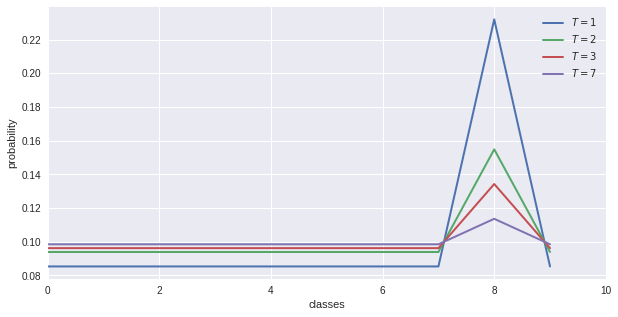

In [0]:
# logits for a random image
v = logits[1]
plt.figure(figsize=(10, 5));
plt.plot(softmax(v), label='$T=1$', linewidth=2);
plt.plot(softmax(v/2), label='$T=2$', linewidth=2);
plt.plot(softmax(v/3), label='$T=3$', linewidth=2);
plt.plot(softmax(v/7), label='$T=7$', linewidth=2);
plt.legend();
plt.xlabel('classes');
plt.ylabel('probability');
plt.xlim([0, 10]);
plt.savefig('5.jpg')

In [0]:
!cp "5.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/testt_graph3.jpg"
!cp "a_0_9443.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/test_img3.jpg"

In [0]:
temperature = 3.0


In [0]:
#!wget https://raw.githubusercontent.com/Ujjwal-9/Knowledge-Distillation/master/squeezenet_weights.hdf5

--2019-02-25 06:45:18--  https://raw.githubusercontent.com/Ujjwal-9/Knowledge-Distillation/master/squeezenet_weights.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3034616 (2.9M) [application/octet-stream]
Saving to: ‘squeezenet_weights.hdf5.1’

squeezenet_weights. 100%[===================>]   2.89M  --.-KB/s    in 0.1s    

2019-02-25 06:45:30 (29.2 MB/s) - ‘squeezenet_weights.hdf5.1’ saved [3034616/3034616]



In [0]:
model = SqueezeNet(weight_decay=1e-4, image_size=299 )#1e-4
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/classification/squeezenet/squeezenet.h5', by_name=True)

# remove softmax
model.layers.pop()

# usual probabilities (change to this if get logits already went thourugh softmax)
logits = model.layers[-1].output
probabilities = Activation('softmax')(logits)

# softed probabilities
#logits_T = Lambda(lambda x: x/temperature)(logits)#temperature
#probabilities_T = Activation('softmax')(logits_T)

#output = concatenate([probabilities, probabilities_T])
model = Model(model.input, probabilities)#output
# now model outputs 512 dimensional vectors

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 149, 149, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
activation_336 (Activation)     (None, 149, 149, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_37 (MaxPooling2D) (None, 74, 74, 64)   0           activation_336[0][0]             
__________________________________________________________________________________________________
fire2/sque

In [0]:
#lambda_const = 0.2

model.compile(
    optimizer=optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

In [0]:

model.fit_generator(
    train_generator, 
    steps_per_epoch=5000//50, epochs=30, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_acc', patience=10, min_delta=0.01),
        ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=2, epsilon=0.007)
    ],
    validation_data=val_generator, 
    validation_steps=3000//50, 
    workers=4
)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/30
100/100 [==============================] - 67s 674ms/step - loss: 0.3976 - acc: 0.8906 - top_k_categorical_accuracy: 0.9970 - val_loss: 0.6350 - val_acc: 0.8287 - val_top_k_categorical_accuracy: 0.9923
Epoch 2/30
100/100 [==============================] - 62s 622ms/step - loss: 0.3930 - acc: 0.8924 - top_k_categorical_accuracy: 0.9976 - val_loss: 0.5731 - val_acc: 0.8390 - val_top_k_categorical_accuracy: 0.9930
Epoch 3/30
100/100 [==============================] - 61s 608ms/step - loss: 0.3872 - acc: 0.8930 - top_k_categorical_accuracy: 0.9976 - val_loss: 0.5593 - val_acc: 0.8417 - val_top_k_categorical_accuracy: 0.9933
Epoch 4/30
100/100 [==============================] - 60s 599ms/step - loss: 0.3694 - acc: 0.8984 - top_k_categorical_accuracy: 0.9974 - val_loss: 0.5991 - val_acc: 0.8333 - val_top_k_categorical_accuracy: 0.9940
Epoch 5/30
100/100 [==============================] - 59s 587ms/step - loss: 0.3483 - acc: 0.9078 - top_k_categorical_accuracy: 0.9980 - val_loss: 0

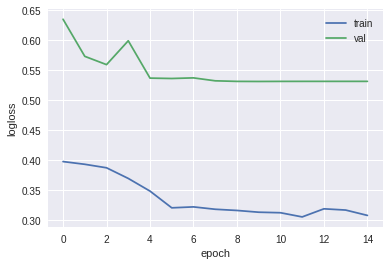

In [0]:
plt.plot(model.history.history['loss'], label='train');
plt.plot(model.history.history['val_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');
plt.savefig('squeezenet_distill_loss.jpg')

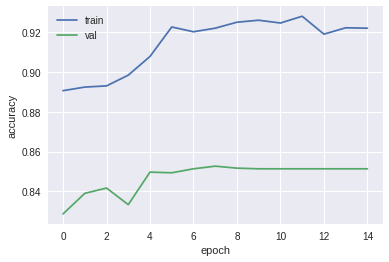

In [0]:
plt.plot(model.history.history['acc'], label='train');
plt.plot(model.history.history['val_acc'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');
plt.savefig('squeezenet_distill_acc.jpg')

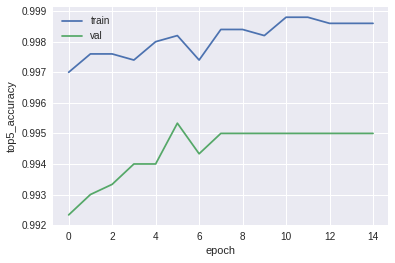

In [0]:
plt.plot(model.history.history['top_k_categorical_accuracy'], label='train');
plt.plot(model.history.history['val_top_k_categorical_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');
plt.savefig('squeezenet_distill_top5_acc.jpg')

In [0]:
val_generator_no_shuffle = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(299, 299),
    batch_size=50, shuffle=False
)

Found 3000 images belonging to 10 classes.


In [0]:
model.evaluate_generator(val_generator_no_shuffle, 80)

[0.5177001601085067, 0.8570000000298024, 0.9955000020563602]

In [0]:
model.save("squeezenet_distill.h5")

In [0]:
data_train_generator = keras.preprocessing.image.ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

test_generator = data_train_generator.flow_from_directory(
    data_dir + 'test', shuffle=False,
    target_size=(299, 299),
    batch_size=50
)

Found 5000 images belonging to 10 classes.


In [0]:
from keras.models import Model,load_model
#vmodel = SqueezeNet(weight_decay=1e-4, image_size=299 )#1e-4
vmodel = load_model('/content/gdrive/My Drive/Colab Notebooks/classification/squeezenet/squeezenet.h5')
vmodel.evaluate_generator(test_generator, 80)

[0.54110177308321, 0.830249996483326, 0.9905000023543835]

In [0]:
model.evaluate_generator(test_generator, 80)

[0.4824540842324495, 0.8440000005066395, 0.9922500029206276]

In [0]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1,steps=STEP_SIZE_TEST)

100/100 [==============================] - 23s 227ms/step


In [0]:
predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
#lbl = [ "airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey" , "ship", "truck" ]  
predictions = [labels[k] for k in predicted_class_indices]

In [0]:
import pandas as pd 
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("squeezenet_distill_results.csv",index=False)

In [0]:
!cp "squeezenet_distill.h5" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/squeezenet.h5"
!cp "squeezenet_distill_results.csv" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/squeezenet_results.csv"
!cp "squeezenet_distill_acc.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/squeezenet_acc.jpg"
!cp "squeezenet_distill_loss.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/squeezenet_loss.jpg"
!cp "squeezenet_distill_top5_acc.jpg" "/content/gdrive/My Drive/Colab Notebooks/classification/distillation_squeezenet/squeezenet_top5_acc.jpg"